# Matching users as client of EvasionBuilder and MatchingUsers modules

In [1]:
%matplotlib inline
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from importlib import reload
import datetime as dt
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))
import EvasionBuilder
from Utils import TransantiagoConstants

* Building complete evasion database via <strong>EvasionBuilder</strong>

In [2]:
processed_evasion = EvasionBuilder.runCompleteProcess()

Original number of rows in complete evasion database is: 97373
Number of duplicated rows in complete evasion database is: 6192
Number of collapsed-duplicated rows in complete evasion database is: 3090
Number of rows in complete evasion database without duplicated rows at all is: 91181
Final number of rows in complete evasion database with collapsed duplicated rows is: 94271


C:\Users\leoca_000\Anaconda3\lib\site-packages\pandas\core\indexing.py:337: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
C:\Users\leoca_000\Anaconda3\lib\site-packages\pandas\core\indexing.py:517: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


The only non-matched user_code services are: 
D06


* Processing complete evasion database depending on necessity

In [3]:
evasion_paradero = processed_evasion[processed_evasion['TP']=='P']
evasion_paradero_first = evasion_paradero[evasion_paradero['N_PUERTA']==1]

In [4]:
print('Number of rows in complete evasion database is: ' + str(len(processed_evasion.index)))
print('Number of rows in evasion in paradero database is: ' + str(len(evasion_paradero.index)))
print('Number of rows in evasion in paradero by first door database is: ' + str(len(evasion_paradero_first.index)))

Number of rows in complete evasion database is: 94271
Number of rows in evasion in paradero database is: 92604
Number of rows in evasion in paradero by first door database is: 33120


* Filtering dates not in common dates. DataFrame "common_dates_evasion" will be the final evasion DataFrame

In [5]:
common_dates = TransantiagoConstants.common_dates
common_dates_timestamp = [pd.to_datetime(x) for x in common_dates]
common_dates_evasion = evasion_paradero_first[evasion_paradero_first['FECHA'].isin(common_dates_timestamp)]

print('Number of rows in complete evasion database filtered by common_dates is: ' + str(len(common_dates_evasion.index))) #Remember to store the number.

Number of rows in complete evasion database filtered by common_dates is: 14632


* Building Etapas DataBase via <strong>RunSilentlyDailyEtapasBuilder</strong> and matching users via <strong>MatchingUsers</strong>

In [6]:
#common_dates = common_dates[:1]
common_dates = ['2017-04-11']

In [7]:
from RunSilentlyDailyEtapasBuilder import RunSilentlyDailyEtapasBuilderClass

In [8]:
import MatchingUsers

In [9]:
summary_evasion_vs_mean = pd.DataFrame()

for date in common_dates:    
    etapas_builder = RunSilentlyDailyEtapasBuilderClass(date)
    processed_sorted_df = etapas_builder.runProcessedProcess()
#    processed_sorted_df = processed_sorted_df[processed_sorted_df['diferencia_tiempo_secs']<=20] <- BE AWARE OF THIS LINE...
    processed_sorted_df['sitio_subida'] = processed_sorted_df['sitio_subida'].str.replace("-", "")
    processed_sorted_df['sitio_subida'] = processed_sorted_df['sitio_subida'].str.replace(" ", "")
    processed_sorted_df['servicio_subida'] =  processed_sorted_df['servicio_subida'].str.replace('T','')
    processed_sorted_df['servicio_subida'] =  processed_sorted_df['servicio_subida'].str.split(' ').str[0]
    
    [evasion_by_date, patentes_by_date, servicios_by_date] = MatchingUsers.simplifyingEvasion(common_dates_evasion,date)
    
    clean_sorted_df = processed_sorted_df[(processed_sorted_df['sitio_subida'].isin(patentes_by_date))&(processed_sorted_df['servicio_subida'].isin(servicios_by_date))]
    clean_sorted_df = clean_sorted_df.reset_index(drop=True)
    clean_sorted_df = clean_sorted_df[clean_sorted_df['diferencia_tiempo_secs']<20]
    
    clean_sorted_df = MatchingUsers.appendingIdExpedicion(clean_sorted_df)
    grouped_clean_sorted_df_1 = MatchingUsers.groupByEtapasDatabase(clean_sorted_df)    
    grouped_clean_sorted_df_2 = MatchingUsers.appendingStartEndCuts(grouped_clean_sorted_df_1)
    grouped_clean_sorted_df_3 = MatchingUsers.slicingEvasionDatabase(grouped_clean_sorted_df_2,evasion_by_date) #This is the final ddbb with full info.
    summary_evasion_vs_mean = pd.concat([summary_evasion_vs_mean,grouped_clean_sorted_df_3]) 

Not found in turnstile database: 1829611


In [10]:
len(evasion_by_date.index) #PASSED

1106

In [11]:
len(clean_sorted_df.index) #PASSED

7165

In [12]:
len(grouped_clean_sorted_df_1) #PASSED

2089

In [13]:
len(grouped_clean_sorted_df_2) #PASSED

2089

In [14]:
len(grouped_clean_sorted_df_3) #PASSED

2089

In [15]:
grouped_clean_sorted_df_3.head()

,sitio_subida,servicio_subida,idExpedicion,par_subida,t_subidamin,t_subidamax,t_subidacount,diferencia_tiempo_secsmean,start_cut,end_cut,count_ev_obs,ingresan,no_validan
0,BJFB62,507,1,L-10-37-20-NS,2017-04-11 08:03:48,2017-04-11 08:03:48,1,2.00,2017-04-11 08:03:18,2017-04-11 08:04:18,0.0,0.0,0.0
1,BJFB62,507,2,T-10-64-PO-20,2017-04-11 08:19:55,2017-04-11 08:19:55,1,0.00,2017-04-11 08:19:25,2017-04-11 08:20:25,0.0,0.0,0.0
2,BJFB62,507,3,T-8-66-PO-15,2017-04-11 08:39:36,2017-04-11 08:39:37,2,4.00,2017-04-11 08:39:06,2017-04-11 08:41:35.500000,0.0,0.0,0.0
3,BJFB62,507,3,T-20-68-NS-5,2017-04-11 08:43:34,2017-04-11 08:43:53,7,3.00,2017-04-11 08:41:35.500000,2017-04-11 08:48:10.500000,0.0,0.0,0.0
4,BJFB62,507,3,E-20-53-PO-5,2017-04-11 08:52:28,2017-04-11 08:52:39,4,3.25,2017-04-11 08:48:10.500000,2017-04-11 08:55:11,0.0,0.0,0.0


In [16]:
summary_evasion_vs_mean.head(20)

,sitio_subida,servicio_subida,idExpedicion,par_subida,t_subidamin,t_subidamax,t_subidacount,diferencia_tiempo_secsmean,start_cut,end_cut,count_ev_obs,ingresan,no_validan
0,BJFB62,507,1,L-10-37-20-NS,2017-04-11 08:03:48,2017-04-11 08:03:48,1,2.000000,2017-04-11 08:03:18,2017-04-11 08:04:18,0.0,0.0,0.0
1,BJFB62,507,2,T-10-64-PO-20,2017-04-11 08:19:55,2017-04-11 08:19:55,1,0.000000,2017-04-11 08:19:25,2017-04-11 08:20:25,0.0,0.0,0.0
2,BJFB62,507,3,T-8-66-PO-15,2017-04-11 08:39:36,2017-04-11 08:39:37,2,4.000000,2017-04-11 08:39:06,2017-04-11 08:41:35.500000,0.0,0.0,0.0
3,BJFB62,507,3,T-20-68-NS-5,2017-04-11 08:43:34,2017-04-11 08:43:53,7,3.000000,2017-04-11 08:41:35.500000,2017-04-11 08:48:10.500000,0.0,0.0,0.0
4,BJFB62,507,3,E-20-53-PO-5,2017-04-11 08:52:28,2017-04-11 08:52:39,4,3.250000,2017-04-11 08:48:10.500000,2017-04-11 08:55:11,0.0,0.0,0.0
5,BJFB62,507,3,T-20-186-NS-5,2017-04-11 08:57:43,2017-04-11 08:57:44,2,1.500000,2017-04-11 08:55:11,2017-04-11 09:04:34.500000,0.0,0.0,0.0
6,BJFB62,507,3,T-20-189-PO-10,2017-04-11 09:11:25,2017-04-11 09:11:33,2,13.500000,2017-04-11 09:04:34.500000,2017-04-11 09:12:03,0.0,0.0,0.0
7,BJFB62,507,4,T-18-156-PO-27,2017-04-11 09:31:55,2017-04-11 09:31:55,1,16.000000,2017-04-11 09:31:25,2017-04-11 09:32:25,0.0,0.0,0.0
8,BJFB62,507,5,L-32-11-45-NS,2017-04-11 15:09:26,2017-04-11 15:09:29,3,2.666667,2017-04-11 15:08:56,2017-04-11 15:16:29.500000,2.0,7.0,1.0
9,BJFB62,507,5,E-18-156-OP-5,2017-04-11 15:23:30,2017-04-11 15:23:48,7,3.000000,2017-04-11 15:16:29.500000,2017-04-11 15:25:40,3.0,15.0,5.0


In [17]:
util_df = summary_evasion_vs_mean[(summary_evasion_vs_mean['diferencia_tiempo_secsmean'].notnull())&(summary_evasion_vs_mean['count_ev_obs']>0)]

In [18]:
len(util_df.index)

310

In [19]:
torniquetesDataPath = "C:/Users/leoca_000/Desktop/Evasion/01_analisis/03_datos/03_BUSESTORNIQUETE/Avance_Consolidado_v2.xlsx"
busesTorniquete_df = pd.read_excel(torniquetesDataPath)
busesTorniquete_df.columns=['sitio_subida','fecha_instalacion']

busesTorniquete_df.loc[:,'sitio_subida'] = busesTorniquete_df.loc[:,'sitio_subida'].str.replace("-", "")
busesTorniquete_df.loc[:,'sitio_subida'] = busesTorniquete_df.loc[:,'sitio_subida'].str.replace(" ", "")

merged_turnstiles_df = pd.merge(util_df,busesTorniquete_df, on='sitio_subida', how='left')
checking_missing = pd.isnull(merged_turnstiles_df['fecha_instalacion'])
print('Not found in turnstile database: ' + str(sum(checking_missing))) #Without turnstiles, then NaT.
#merged_turnstiles_df.loc[:,'fecha_instalacion'] = pd.to_datetime(merged_turnstiles_df.loc[:,'fecha_instalacion'])

Not found in turnstile database: 260


In [20]:
merged_turnstiles_df.head()

,sitio_subida,servicio_subida,idExpedicion,par_subida,t_subidamin,t_subidamax,t_subidacount,diferencia_tiempo_secsmean,start_cut,end_cut,count_ev_obs,ingresan,no_validan,fecha_instalacion
0,BJFB62,507,5,L-32-11-45-NS,2017-04-11 15:09:26,2017-04-11 15:09:29,3,2.666667,2017-04-11 15:08:56,2017-04-11 15:16:29.500000,2.0,7.0,1.0,NaT
1,BJFB62,507,5,E-18-156-OP-5,2017-04-11 15:23:30,2017-04-11 15:23:48,7,3.000000,2017-04-11 15:16:29.500000,2017-04-11 15:25:40,3.0,15.0,5.0,NaT
2,BJFB62,507,5,T-18-156-OP-30,2017-04-11 15:27:32,2017-04-11 15:27:32,1,2.000000,2017-04-11 15:25:40,2017-04-11 15:29:03.500000,2.0,5.0,2.0,NaT
3,BJFB62,507,5,T-18-156-OP-40,2017-04-11 15:30:35,2017-04-11 15:30:37,2,6.500000,2017-04-11 15:29:03.500000,2017-04-11 15:32:32.500000,1.0,7.0,3.0,NaT
4,BJFB62,507,5,T-18-156-OP-53,2017-04-11 15:34:28,2017-04-11 15:34:28,1,2.000000,2017-04-11 15:32:32.500000,2017-04-11 15:36:27.500000,1.0,4.0,2.0,NaT


In [21]:
type(merged_turnstiles_df.loc[0,'t_subidamin'])

pandas._libs.tslib.Timestamp

In [22]:
type(merged_turnstiles_df.loc[46,'fecha_instalacion'])

pandas._libs.tslib.Timestamp

In [23]:
merged_turnstiles_df.loc[:,'si_torniquete']=merged_turnstiles_df.loc[:,'fecha_instalacion'].notnull()

In [24]:
merged_turnstiles_df_noturns = merged_turnstiles_df[(merged_turnstiles_df['si_torniquete']==False) | 
                                                           ((merged_turnstiles_df['si_torniquete']==True) & (merged_turnstiles_df['t_subidamin']<=merged_turnstiles_df['fecha_instalacion']))]

In [25]:
merged_turnstiles_df_noturns.loc[:,'evasion_rate'] = merged_turnstiles_df_noturns.loc[:,'no_validan'] / merged_turnstiles_df_noturns.loc[:,'ingresan']

C:\Users\leoca_000\Anaconda3\lib\site-packages\pandas\core\indexing.py:337: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
C:\Users\leoca_000\Anaconda3\lib\site-packages\pandas\core\indexing.py:517: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


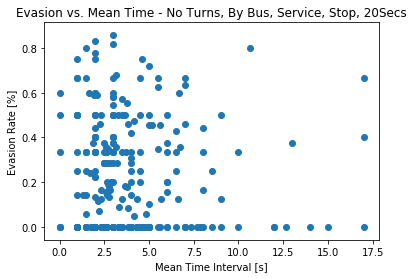

In [28]:
fig_1, ax_1 = plt.subplots()

ax_1.scatter(merged_turnstiles_df_noturns['diferencia_tiempo_secsmean'],merged_turnstiles_df_noturns['evasion_rate'])
ax_1.set_title('Evasion vs. Mean Time - No Turns, By Bus, Service, Stop, 20Secs')
ax_1.set_xlabel('Mean Time Interval [s]')
ax_1.set_ylabel('Evasion Rate [%]')

plt.savefig('C:/Users/leoca_000/Desktop/Evasion/03_report/02_Figs/9_20Secs_EvasionVsMeanTimeByBusByServiceByStop.pdf')